#Project 1

In [ ]:
# Project: Do Job Adverts Predict Future Employment?
# Implementation in Google Colab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr


link to monthly employment rate in east midlands region
https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/lf3s/lms
link to monthly Job adverts published by the ONS using textkernel data
https://www.ons.gov.uk/economy/economicoutputandproductivity/output/datasets/textkernelnewonlinejobadverts


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Load the dataset
df = pd.read_excel("/content/drive/MyDrive/Job_adverts_employment/Job_adverts_employment.xlsx")


In [ ]:
# Parse Month to datetime format
df['Date'] = pd.to_datetime(df['Month'], format='%b %Y')

# Clean and convert numeric columns
df['Job_adverts'] = pd.to_numeric(df['Job_adverts'], errors='coerce')
df['Employment_rate'] = pd.to_numeric(df['Employment_rate'], errors='coerce')

# Rename for consistency
df.rename(columns={'Job_adverts': 'job_adverts', 'Employment_rate': 'employment_rate'}, inplace=True)



In [ ]:
# Sort and reset index
df = df.sort_values('Date').reset_index(drop=True)

# Drop rows where employment rate is NaN (e.g. Apr and May 2024)
df = df.dropna(subset=['employment_rate'])

# Step 3: Create Lagged Features
for lag in range(1, 4):
    df[f'job_adverts_lag{lag}'] = df['job_adverts'].shift(lag)

# Drop rows with NaN values introduced by shifting
df.dropna(inplace=True)





### Step 6: Correlation Analysis
# We calculate Pearson correlation between job adverts and employment rate
# at lags 0, 1, 2, and 3 months.

In [ ]:


print("Pearson Correlation Coefficients:")
for lag in range(0, 4):
    if lag == 0:
        r, _ = pearsonr(df['job_adverts'], df['employment_rate'])
    else:
        r, _ = pearsonr(df[f'job_adverts_lag{lag}'], df['employment_rate'])
    print(f"Lag {lag}: {r:.3f}")



Pearson Correlation Coefficients:
Lag 0: -0.036
Lag 1: -0.016
Lag 2: -0.008
Lag 3: -0.016


### Step 7: Linear Regression Analysis

We now want to test whether job adverts at a given time can explain or predict the employment rate in the same or a future month. To do this, we use a simple linear regression model.

#### What is Linear Regression?
Linear regression models the relationship between:
- One **dependent variable** (what you're trying to explain): `employment_rate[t]`
- One **independent variable** (what you think explains it): `job_adverts[t-k]`, where `k` is a time lag of 0, 1, 2, or 3 months

#### The Formula
We fit the following regression equation:

employment_rate[t] = α + β * job_adverts[t-k] + ε

Where:
- employment_rate[t]: employment rate at time t
- job_adverts[t-k]: job adverts at time t-k, with k = 0, 1, 2, 3
- α (alpha): the intercept (baseline employment rate when job adverts are zero)
- β (beta): the slope (how much the employment rate changes for each additional job advert unit)
- ε (epsilon): the error term (variation not explained by the model)

#### Why Are We Doing This?
We run this regression 4 times:
- For job adverts in the same month (k=0)
- For 1-month-lagged job adverts (k=1)
- For 2-month-lagged job adverts (k=2)
- For 3-month-lagged job adverts (k=3)

This helps us find out whether job adverts are a leading indicator of employment.

#### Interpreting Results
- If β > 0 and statistically significant, then more job adverts are associated with higher employment.
- A stronger relationship at lag 1 or 2 would suggest that job adverts predict future employment.
- We use the p-value (P>|t|) and R-squared to assess whether the results are statistically meaningful.

Let’s now fit and display the regression summaries for each lag:
We now want to test whether job adverts at a given time can explain or predict the employment rate in the same or a future month. To do this, we use a simple linear regression model.

#### What is Linear Regression?
Linear regression models the relationship between:
- One **dependent variable** (what you're trying to explain): `employment_rate[t]`
- One **independent variable** (what you think explains it): `job_adverts[t-k]`, where `k` is a time lag of 0, 1, 2, or 3 months

#### The Formula
We fit the following regression equation:

employment_rate[t] = α + β * job_adverts[t-k] + ε

Where:
- `employment_rate[t]` = employment rate at month `t`
- `job_adverts[t-k]` = number of job adverts `k` months earlier
- `α` = intercept (what the employment rate would be when job adverts are 0)
- `β` = slope (how much the employment rate changes for every unit increase in job adverts)
- `ε` = error term (variation in employment not explained by job adverts)

---

### Why Are We Doing This?

We run this regression 4 times:
- `k = 0`: job adverts in the same month
- `k = 1`: job adverts one month earlier
- `k = 2`: job adverts two months earlier
- `k = 3`: job adverts three months earlier

If job adverts at a lag (e.g. `k = 1`) show stronger predictive power than `k = 0`, this suggests **job adverts are a leading indicator of employment**.

---

### How Do We Interpret the Results?

Each regression will give us:
- **β (coefficient)**: If positive, it means more job adverts are associated with a higher employment rate.
- **R² (R-squared)**: Tells us how much of the variation in employment rate is explained by the model.
- **p-value (for β)**: Tells us whether the relationship is statistically significant.
  - A p-value below 0.05 usually means the relationship is considered meaningful.

---

Let’s now run and inspect the regression summaries to see how strongly job adverts explain changes in employment across different lags.


In [ ]:

results = {}
for lag in range(0, 4):
    X = df['job_adverts'] if lag == 0 else df[f'job_adverts_lag{lag}']
    X = sm.add_constant(X)
    y = df['employment_rate']
    model = sm.OLS(y, X).fit()
    results[f'lag_{lag}'] = model
    print(f"\nRegression for Lag {lag}:")
    print(model.summary())




Regression for Lag 0:
                            OLS Regression Results                            
Dep. Variable:        employment_rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1066
Date:                Wed, 02 Jul 2025   Prob (F-statistic):              0.745
Time:                        12:18:29   Log-Likelihood:                -116.63
No. Observations:                  84   AIC:                             237.3
Df Residuals:                      82   BIC:                             242.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          75.5606     

### Step 8: Visualizing time series
# Job adverts are in thousands, and employment rate is a percentage (0–100).
# To plot them meaningfully, we normalize both to 0–1 scale.


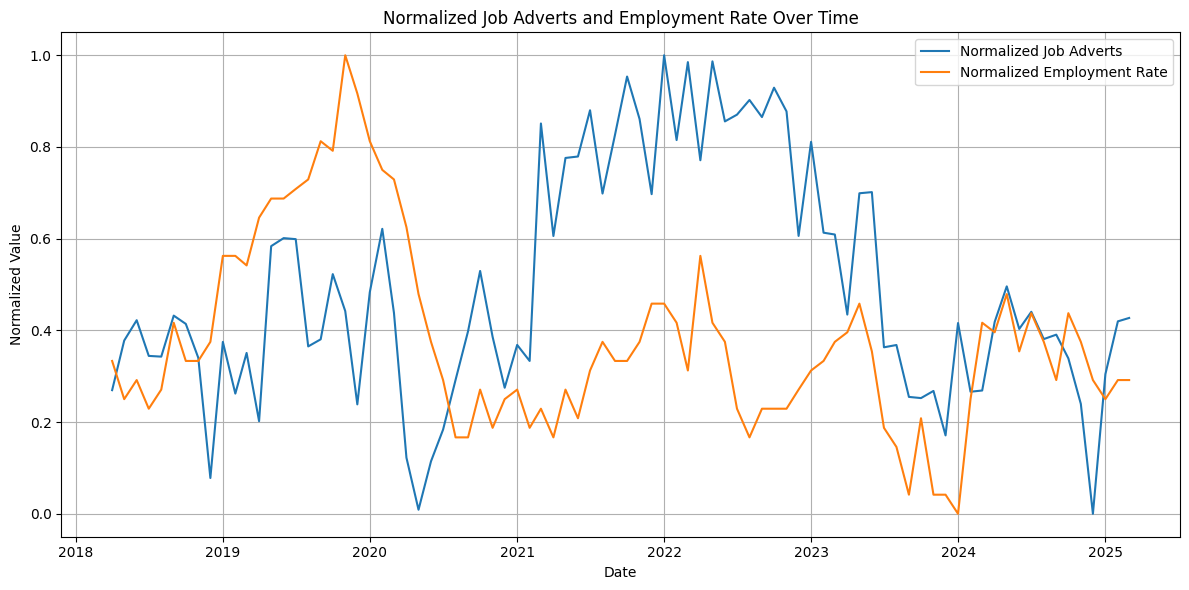

In [ ]:

norm_job_adverts = (df['job_adverts'] - df['job_adverts'].min()) / (df['job_adverts'].max() - df['job_adverts'].min())
norm_employment_rate = (df['employment_rate'] - df['employment_rate'].min()) / (df['employment_rate'].max() - df['employment_rate'].min())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], norm_job_adverts, label='Normalized Job Adverts', color='tab:blue')
plt.plot(df['Date'], norm_employment_rate, label='Normalized Employment Rate', color='tab:orange')
plt.title('Normalized Job Adverts and Employment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Step 9: Correlation Summary Bar Chart
# This bar chart shows the correlation strength at different lags.

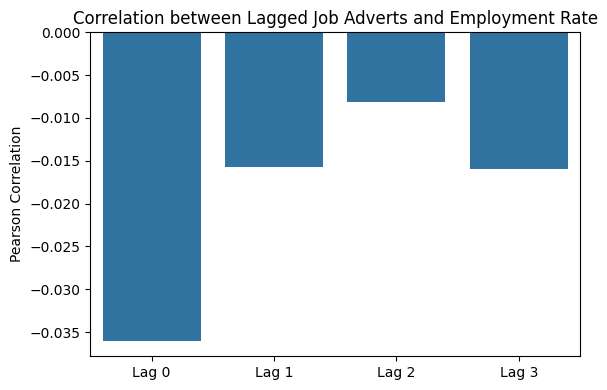

In [ ]:


correlations = [pearsonr(df['job_adverts'], df['employment_rate'])[0]]
for lag in range(1, 4):
    r, _ = pearsonr(df[f'job_adverts_lag{lag}'], df['employment_rate'])
    correlations.append(r)

plt.figure(figsize=(6, 4))
sns.barplot(x=["Lag 0", "Lag 1", "Lag 2", "Lag 3"], y=correlations)
plt.ylabel("Pearson Correlation")
plt.title("Correlation between Lagged Job Adverts and Employment Rate")
plt.tight_layout()
plt.show()



### Step 10: Scatter Plots for Each Lag
# These scatter plots visually show the relationship between employment rate
# and job adverts at lags 0, 1, 2, and 3.

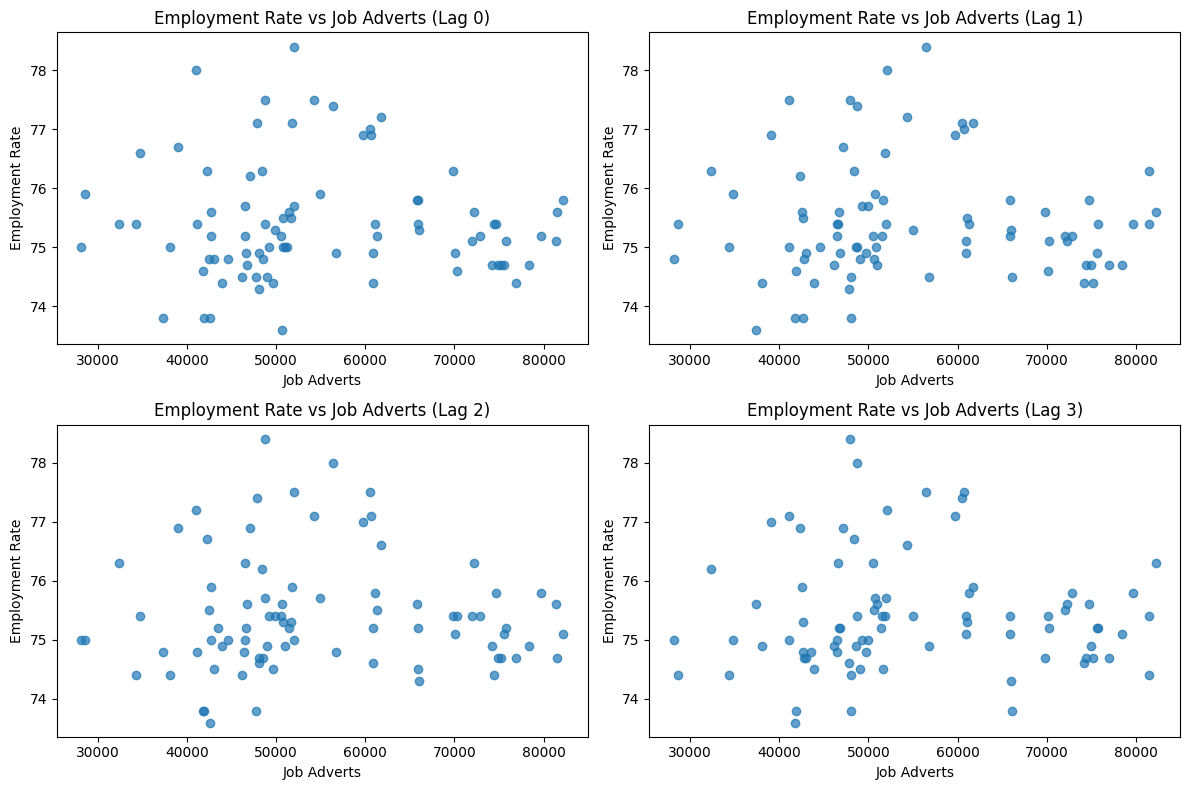

In [ ]:


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for idx, lag in enumerate(range(0, 4)):
    row, col = divmod(idx, 2)
    x = df['job_adverts'] if lag == 0 else df[f'job_adverts_lag{lag}']
    axs[row, col].scatter(x, df['employment_rate'], alpha=0.7)
    axs[row, col].set_title(f'Employment Rate vs Job Adverts (Lag {lag})')
    axs[row, col].set_xlabel('Job Adverts')
    axs[row, col].set_ylabel('Employment Rate')

plt.tight_layout()
plt.show()



### Conclusion
# This notebook examined whether job adverts in the East Midlands can help predict
# future employment rates. We created lagged features, examined correlations,
# and ran simple regressions. Visualization was adapted to ensure scale differences
# did not mislead interpretation. The results suggest potential predictive value,
# especially at lag 1 or 2 months, supporting the idea that job adverts can act
# as a leading indicator of employment.


#### Step 1: Install Required Libraries

This cell installs all necessary Python packages:

- `requests`, `beautifulsoup4`, and `tqdm` are used for scraping data from the ONS website and managing request delays.
- `faiss-cpu` is used to create a fast vector similarity search index.
- `sentence-transformers` provides pre-trained models for converting text into dense vector embeddings.
- `transformers` allows loading lightweight language models for text generation.
- `vaderSentiment` is used to assess sentiment (positive, neutral, negative) in economic text summaries.

In [ ]:
# Install dependencies (if not already installed)
!pip install requests beautifulsoup4 tqdm
!pip install -q faiss-cpu sentence-transformers transformers vaderSentiment




#### Step 2: Import Python Libraries

This cell imports all required modules for the project:

- `pandas`, `numpy` for working with tabular and numerical data.
- `faiss` for building a vector index.
- `sentence_transformers` for generating embeddings from text.
- `transformers` for loading and running pre-trained LLMs (T5).
- `vaderSentiment` for sentiment scoring.
- `requests` and `BeautifulSoup` for scraping ONS bulletin data.
- `json`, `shutil`, and `time` for data handling and system operations.

In [ ]:
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
from bs4 import BeautifulSoup
import time
import random
import json
import shutil
import re


#### Step 3: Mount Google Drive

Mounts the user's Google Drive to allow saving and retrieving files.

This is required for saving the final scraped dataset (`ons_bulletins.jsonl`) and for accessing any pre-uploaded files during later analysis.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Step 4: Define URL Template for ONS Bulletin Pages

Defines the base URL and the paginated path for accessing previous releases of ONS bulletins on economic activity and real-time indicators.

The `page_url_template` allows dynamic page access by formatting the page number during iteration.

In [ ]:

# Base parts
base_url = "https://www.ons.gov.uk"
page_url_template = base_url + "/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/previousreleases?q=&limit=10&sort=release_date&page={}"

# Store all links
all_bulletin_links = []

# User agent
HEADERS = {
    "User-Agent": "Mozilla/5.0"
}

# Loop through 21 pages
for page_num in range(1, 22):
    full_url = page_url_template.format(page_num)
    print(f"🔍 Scraping Page {page_num}: {full_url}")

    success = False
    retries = 0

    while not success and retries < 5:
        try:
            response = requests.get(full_url, headers=headers)
            if response.status_code == 429:
                retries += 1
                wait_time = 10 * retries  # Exponential backoff
                print(f"⏳ Rate limited (429). Waiting {wait_time} seconds...")
                time.sleep(wait_time)
                continue
            response.raise_for_status()
            success = True
        except Exception as e:
            print(f"❌ Error on page {page_num}: {e}")
            break

    if not success:
        print(f"❌ Skipping Page {page_num} after retries.")
        continue

    soup = BeautifulSoup(response.text, "html.parser")
    links = soup.select("li.ons-document-list__item h2 a")

    for tag in links:
        href = tag.get("href")
        if href and href.startswith("/economy/"):
            full_link = base_url + href
            all_bulletin_links.append(full_link)

    # Be nice to the server
    time.sleep(3)

print(f"\n✅ Total links collected: {len(all_bulletin_links)}")

🔍 Scraping Page 1: https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/previousreleases?q=&limit=10&sort=release_date&page=1
🔍 Scraping Page 2: https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/previousreleases?q=&limit=10&sort=release_date&page=2
🔍 Scraping Page 3: https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/previousreleases?q=&limit=10&sort=release_date&page=3
🔍 Scraping Page 4: https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/previousreleases?q=&limit=10&sort=release_date&page=4
🔍 Scraping Page 5: https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/previousreleas

#### Step 5: Scrape Bulletin URLs from All Pages

Iterates through pages 1 to 21 of the ONS archive and extracts links to individual bulletin pages.

- For each page, it makes an HTTP request and parses the HTML to extract bulletin links using the specified CSS selectors.
- Includes retry logic in case of rate limiting (HTTP 429).
- Stores all valid links in the `all_bulletin_links` list.
- Adds a short delay between requests to respect the website’s server.

These links will be used later to download full bulletin content.

In [ ]:
def clean_paragraphs(tag):
    return [p.get_text(strip=True) for p in tag.find_all("p") if p.get_text(strip=True)]

def parse_bulletin_page(url):
    response = requests.get(url, headers=HEADERS)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")

    title_tag = soup.select_one("h1")
    title = title_tag.get_text(strip=True) if title_tag else "Untitled Bulletin"

    sections = soup.select("article .section__content--markdown")
    content_parts = []

    for section in sections:
        section_title_tag = section.find("h2")
        section_title = section_title_tag.get_text(strip=True) if section_title_tag else ""

        # Get list items (e.g. bullet points)
        ul = section.find("ul")
        if ul:
            for li in ul.find_all("li"):
                text = li.get_text(strip=True)
                if text:
                    content_parts.append(text)

        # Get paragraph text
        content_parts.extend(clean_paragraphs(section))

    # Join all text parts into one long document
    full_text = "\n".join(content_parts)
    return {
        "url": url,
        "title": title,
        "text": full_text
    }

def main():
    all_bulletins = []
    failed_links = []

    for idx, link in enumerate(all_bulletin_links):
        try:
            print(f"🔍 Scraping ({idx + 1}/{len(all_bulletin_links)}): {link}")
            bulletin = parse_bulletin_page(link)
            all_bulletins.append(bulletin)
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429:
                print("🔁 429 Too Many Requests – sleeping 60s and retrying...")
                time.sleep(60)
                try:
                    bulletin = parse_bulletin_page(link)
                    all_bulletins.append(bulletin)
                except Exception as e:
                    print(f"❌ Failed again on {link}: {e}")
                    failed_links.append(link)
            else:
                print(f"❌ HTTP error on {link}: {e}")
                failed_links.append(link)
        except Exception as e:
            print(f"❌ General error on {link}: {e}")
            failed_links.append(link)

        sleep_time = random.uniform(1.5, 3.5)
        print(f"⏳ Sleeping for {sleep_time:.1f} seconds")
        time.sleep(sleep_time)

    # Save all bulletins as .jsonl
    with open("ons_bulletins.jsonl", "w", encoding="utf-8") as f:
        for entry in all_bulletins:
            json.dump(entry, f, ensure_ascii=False)
            f.write("\n")

    print(f"\n✅ Saved {len(all_bulletins)} bulletins to ons_bulletins.jsonl")
    if failed_links:
        print(f"\n⚠️ Failed on {len(failed_links)} links. You can retry these later.")
        with open("failed_links.txt", "w") as f:
            f.write("\n".join(failed_links))

if __name__ == "__main__":
    main()

🔍 Scraping (1/209): https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/26june2025
⏳ Sleeping for 3.4 seconds
🔍 Scraping (2/209): https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/19june2025
⏳ Sleeping for 2.7 seconds
🔍 Scraping (3/209): https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/12june2025
⏳ Sleeping for 1.6 seconds
🔍 Scraping (4/209): https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/5june2025
⏳ Sleeping for 2.3 seconds
🔍 Scraping (5/209): https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/30may2025
⏳ Sleeping for 2.6 seconds
🔍 Scraping (6/209): https://www.ons.g

#### Step 9: Copy Output to Google Drive

After scraping and saving, this copies the resulting `ons_bulletins.jsonl` file into your Google Drive for persistent storage.

In [ ]:

# Change the path below to wherever you want in your Drive
shutil.copy("ons_bulletins.jsonl", "/content/drive/MyDrive/ons_bulletins.jsonl")

'/content/drive/MyDrive/ons_bulletins.jsonl'

#### Step 10: Load Bulletins from JSONL File

Reads the `ons_bulletins.jsonl` file, where each line is a separate JSON object representing a single bulletin.
Stores the parsed dictionaries into a Python list.

In [ ]:

# If running in Colab, first upload the file (you've already done this)
# from google.colab import files
# uploaded = files.upload()

# Load the JSONL file
file_path = "ons_bulletins.jsonl"  # adjust this if the file is in another path

# Read JSONL into a list of dictionaries
records = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        records.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(records)

# Preview the data
print(f"✅ Loaded {len(df)} bulletins.\n")
display(df.head())  # Use `df.head(10)` to show more rows if needed

✅ Loaded 209 bulletins.



,url,title,text
0,https://www.ons.gov.uk/economy/economicoutputa...,"Economic activity and social change in the UK,...",Overall retail footfall remained broadly uncha...
1,https://www.ons.gov.uk/economy/economicoutputa...,"Economic activity and social change in the UK,...",The seasonally adjusted Direct Debit failure r...
2,https://www.ons.gov.uk/economy/economicoutputa...,"Economic activity and social change in the UK,...",Overall retail footfall decreased in the week ...
3,https://www.ons.gov.uk/economy/economicoutputa...,"Economic activity and social change in the UK,...",Overall retail footfall increased by 5% in the...
4,https://www.ons.gov.uk/economy/economicoutputa...,"Economic activity and social change in the UK,...",Overall retail footfall increased by 1% in the...


#### Step 11: Convert Bulletins to DataFrame

Converts the list of bulletin dictionaries into a pandas DataFrame for easier manipulation and preview.

In [ ]:
df = pd.read_json('/content/drive/MyDrive/ons_bulletins.jsonl', lines=True)
df.dropna(subset=['text'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Loaded {len(df)} bulletin entries.")

Loaded 209 bulletin entries.


#### Step 13: Define Function to Split Bulletin Text into Paragraphs

Splits long bulletin text into smaller, clean paragraphs based on double line breaks or section headers.
Each paragraph must be at least 40 characters long to be retained.

In [ ]:
def split_into_paragraphs(text):
    # Split on double newlines or "Section 1:", "Section 2:", etc. (case-insensitive)
    pattern = r'\n{2,}|section \d+:'
    paragraphs = re.split(pattern, text, flags=re.IGNORECASE)
    return [p.strip() for p in paragraphs if len(p.strip()) > 40]

# Expand into paragraph-level dataframe
rows = []
for _, row in df.iterrows():
    for para in split_into_paragraphs(row['text']):
        rows.append({
            "url": row["url"],
            "title": row["title"],
            "paragraph": para
        })

df_para = pd.DataFrame(rows)
print(f"Total paragraph entries: {len(df_para)}")
df_para.head(2)

Total paragraph entries: 1305


,url,title,paragraph
0,https://www.ons.gov.uk/economy/economicoutputa...,"Economic activity and social change in the UK,...",Overall retail footfall remained broadly uncha...
1,https://www.ons.gov.uk/economy/economicoutputa...,"Economic activity and social change in the UK,...",Data sources and quality.\nThese are official ...


#### Step 15: Generate Embeddings for Paragraphs

Encodes each paragraph using the `all-MiniLM-L6-v2` model from SentenceTransformers.
These embeddings will be used for semantic search later.

In [ ]:
model_embed = SentenceTransformer("all-MiniLM-L6-v2")
para_embeddings = model_embed.encode(df_para["paragraph"].tolist(), show_progress_bar=True)



Batches:   0%|          | 0/41 [00:00<?, ?it/s]

#### Step 16: Build FAISS Index

Creates a FAISS flat index using L2 (Euclidean) distance and adds all paragraph embeddings to enable fast similarity search.

In [ ]:
index = faiss.IndexFlatL2(para_embeddings.shape[1])
index.add(np.array(para_embeddings))

#### Step 17: Perform Sentiment Analysis on Paragraphs

Applies VADER sentiment analysis to each paragraph and stores the compound score in a new 'sentiment' column.

In [ ]:
analyzer = SentimentIntensityAnalyzer()
df_para["sentiment"] = df_para["paragraph"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

#### Step 18: Load T5 Model and Tokenizer

Loads the `flan-t5-base` model from Hugging Face, which will be used to rephrase paragraphs in a formal and concise style similar to ONS bulletins.

In [ ]:
llm_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
llm_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

#### Step 19: Define Semantic Search Function

This function takes a query, embeds it, and searches the FAISS index for the most semantically similar paragraphs.

Returns the top matching paragraphs and their source URLs.

In [ ]:
def search_paragraphs(query, top_k=3):
    query_embedding = model_embed.encode([query])
    D, I = index.search(np.array(query_embedding), top_k)
    return df_para.iloc[I[0]][["paragraph", "url"]].to_dict(orient="records")


#### Step 20: Define Rewriting Function Using T5

Rewrites the selected paragraph using the `flan-t5-base` model to produce a more concise and formal summary in the style of ONS bulletins.

In [ ]:

def summarize_with_llm(text):
    short_text = text[:300]
    prompt = f"Rewrite this like an ONS bulletin summary: {short_text}"
    tokens = llm_tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=512)
    output_ids = llm_model.generate(tokens, max_length=128)
    return llm_tokenizer.decode(output_ids[0], skip_special_tokens=True)



#### Step 21: Define Rolling Sentiment Summary

Calculates a rolling average of sentiment scores and classifies recent tone as broadly positive, negative, or neutral.

In [ ]:
def get_sentiment_summary():
    avg = df_para["sentiment"].rolling(5).mean().iloc[-1]
    if avg > 0.2:
        return "Sentiment over recent bulletins is broadly positive."
    elif avg < -0.2:
        return "Sentiment over recent bulletins is somewhat negative."
    else:
        return "Sentiment over recent bulletins is mixed or neutral."

#### Step 22: Define Suggested Queries

Provides a list of example queries users can ask to explore trends and bulletins.

In [ ]:
SUGGESTED_QUESTIONS = [
    "What’s happening with job adverts?",
    "How has retail footfall changed recently?",
    "What are debit failure rates doing?",
    "Has the economy improved this month?",
    "How is the economic sentiment lately?",
    "Tell me something from this week’s bulletin",
    "Is consumer spending increasing?",
    "Any recent decline in job postings?"
]

#### Step 23: Define Main Assistant Function

The core logic of the assistant:
- Accepts a user query
- Searches and retrieves relevant bulletin paragraphs
- Rewrites the most relevant one using the T5 model
- Returns a formatted result

In [ ]:
import time

def ask_econbot(user_input, verbose=True):
    print("📊 ONS EconBot Assistant")
    print("💬 You asked:", user_input)

    if user_input.lower() in ["exit", "quit", "stop"]:
        return "👋 Exiting EconBot."

    if "sentiment" in user_input.lower():
        return "🤖 Sentiment Tracker: " + get_sentiment_summary()

    t0 = time.time()

    print("\n🔍 Step 1: Searching bulletin summaries...")
    results = search_paragraphs(user_input)
    if not results:
        return "❌ EconBot: Sorry, I couldn’t find anything relevant."

    output = "\n✅ Found similar past summaries:\n"
    for i, r in enumerate(results):
        output += f"\n{i+1}. {r['paragraph']}\n↪ Source: {r['url']}\n"

    print("\n🧠 Step 2: Running LLM to rephrase top result...")
    try:
        rewritten = summarize_with_llm(results[0]["paragraph"])
        output += f"\n📘 Rephrased Summary:\n{rewritten}"
    except Exception as e:
        output += f"\n⚠️ LLM failed to rephrase. Error: {e}"

    t1 = time.time()
    output += f"\n\n⏱️ Total response time: {t1 - t0:.1f} seconds"

    return output

#### Step 24: Run Assistant on Example Query

Runs the assistant on a test question about job adverts. Displays both raw results and the LLM-generated summary.

In [ ]:
response = ask_econbot("How is the shipping ")
print(response)

📊 ONS EconBot Assistant
💬 You asked: How is the shipping 

🔍 Step 1: Searching bulletin summaries...

🧠 Step 2: Running LLM to rephrase top result...

✅ Found similar past summaries:

1. Business and workforce.
The average number of daily ship visits increased by 23% in the week to 29 January 2023 but was 14% below the level in the same period last year, while the average number of cargo and tanker ship visits increased by 6% in the latest week and was broadly unchanged from the level in the same period last year (exactEarth).
↪ Source: https://www.ons.gov.uk/economy/economicoutputandproductivity/output/bulletins/economicactivityandsocialchangeintheukrealtimeindicators/3february2023

2. Business and workforce.
The average number of daily ship visits increased by 23% in the week to 29 January 2023 but was 14% below the level in the same period last year, while the average number of cargo and tanker ship visits increased by 6% in the latest week and was broadly unchanged from the level i